# Solving Simon's problem with a quantum computer

In this section, we aim to solve the Simon's problem with a quantum computer. The Simon's problem states that:

There is a function implemented by an oracle with the property:

$$
\begin{equation}
    f(x) = f(x \oplus s)
\end{equation}
$$


where $s$ is either $0^n$ or a fixed unknown bit string. Find the unknown bitstring $s$.

In this section, we show how to use QURI Parts to implement the algorithm that solves Simon's problem.

## Oracle function and circuit

Suppose the function input is a bit string of length $n$, the oracle is a quantum circuit with $2n$ qubits. In this set up, the oracle is implmented with a unitary matrix that satisfies the condition:

$$
\begin{equation}
    U_f |j \rangle | i \rangle = |j \oplus f(i) \rangle | i \rangle,
\end{equation}
$$
where in the left hand side of the equation, $| j \rangle$ represents the second half of the qubits and $| i \rangle$ represents the first half of the qubits. The function $f$ here is given by:

$$
\begin{equation}
    f(x) = \min(x \oplus s, x)
\end{equation}
$$

where $s$ is the unknown bit string to be solved for by the algorithm. With the above equations, we can implement the oracle as a circuit containing a unitary gate acting on all $2n$ qubits.

In [ ]:
import numpy as np  
from quri_parts.core.utils.binary_field import BinaryArray, BinaryMatrix  
from quri_parts.circuit import QuantumCircuit  
from functools import partial  
from typing import Callable  
from typing_extensions import TypeAlias

In [ ]:
OracleFunction: TypeAlias = Callable[[int], int]

def oracle_function(x: int, s: int) -> int:
    return min(x^s, x)

def get_simon_oracle(s: int, bit_length: int) -> tuple[QuantumCircuit, OracleFunction]:
    n_qubits = 2 * bit_length
    U = np.zeros((2**n_qubits, 2**n_qubits))
    for i in range(2**bit_length):
        for j in range(2**bit_length):
            # U|j>|i> = |j + f(i)>|i>
            # <j + f(i)| <i|U|j> |i> = 1
            oracle_output = ((j^oracle_function(i, s)) << bit_length) + i
            oracle_input = (j << bit_length) + i
            U[oracle_output, oracle_input] = 1
    circuit = QuantumCircuit(n_qubits)
    circuit.add_UnitaryMatrix_gate(range(n_qubits), U)
    return circuit, partial(oracle_function, s=s)

Now, let's examine if our oracle correctly implements the function

$$
\begin{equation}
    f(x) = \min(x \oplus s, x)
\end{equation}
$$
Here we assume $s=0011$, the bit string's length is 4 and check if $U|0000\rangle|i\rangle = |f(i)\rangle|i\rangle$.

In [ ]:
import pandas as pd
import numpy as np
from quri_parts.qulacs.simulator import evaluate_state_to_vector
from quri_parts.core.state import ComputationalBasisState

n_bit_len = 4
s = 0b0011
oracle, oracle_func = get_simon_oracle(s, n_bit_len)

recorder = {}
# Iterate over U|0000>|i>.
for i in range(2**n_bit_len):
    out_state = evaluate_state_to_vector(
        ComputationalBasisState(2*n_bit_len, bits=i).with_gates_applied(oracle)
    ).vector
    second_register_out = np.where(out_state == 1)[0][0] >> n_bit_len
    expected = oracle_func(i)
    recorder[i] = {"y_oracle": second_register_out, "y_expected": expected}

In [ ]:
print(pd.DataFrame(recorder).T.reset_index().rename(columns={"index": "x"}).set_index("x").T.to_markdown())

|            |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |   10 |   11 |   12 |   13 |   14 |   15 |
|:-----------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|-----:|-----:|-----:|-----:|-----:|-----:|
| y_oracle   |   0 |   1 |   1 |   0 |   4 |   5 |   5 |   4 |   8 |   9 |    9 |    8 |   12 |   13 |   13 |   12 |
| y_expected |   0 |   1 |   1 |   0 |   4 |   5 |   5 |   4 |   8 |   9 |    9 |    8 |   12 |   13 |   13 |   12 |


With the table above, we have confirmed that the oracle is correctly implemented.

## The algorithm for solving Simon's problem

The algorithm for solving Simon's problem consists of 2 parts. One quantum and the other classical. Here, we list out the explicit algorithm.  

- (Quantum) Execute the quantum circuit multiple times to collect a set of equations
$$
    \begin{align}
        &x_0^{(1)} s_0 \oplus \cdots \oplus x_{n-1}^{(1)}s_{n-1} = 0 \nonumber \\
        & \qquad\qquad\qquad\vdots \\
        &x_0^{(M)} s_0 \oplus \cdots \oplus x_{n-1}^{(M)}s_{n-1} = 0 \nonumber 
    \end{align}
$$
- (Classical) Solve the above equation to obtain the desired solution $s = s_{n-1}\cdots s_0$


The variable $M$ in the first part of the algorithm indicating the number of circuit execution in order to obtain a solution for $s$ in the classical step. As $s$ is an n-bit bit string, the number of circuit execution $M$ should at least be $n-1$ times in order for us to obtain a non-trivial solution. If $M > n-1$ that means that some circuit executions produce linear dependent equations so we need to throw them away until we get $n-1$ linear independent equations.

### Building the quatum circuit

The algorithm circuit is given by the following figure

![png](simon_algoritm_circuit.png)

Now we are ready to build the quantum circuit

In [ ]:
def get_simons_algorithm_circuit(oracle: QuantumCircuit) -> QuantumCircuit:
    n_qubits = oracle.qubit_count
    bit_length = n_qubits // 2
    circuit = QuantumCircuit(n_qubits, cbit_count=n_qubits)

    for i in range(bit_length):
        circuit.add_H_gate(i)
    
    circuit.extend(oracle)
    
    for i in range(bit_length):
        circuit.add_H_gate(i)
    
    return circuit

In [ ]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
oracle, _ = get_simon_oracle(s=0b01, bit_length=2)
algorithm_circuit = get_simons_algorithm_circuit(oracle)
draw_circuit(algorithm_circuit)

   ___     ___     ___  
  | H |   |Mat|   | H | 
--|0  |---|2  |---|3  |-
  |___|   |   |   |___| 
   ___    |   |    ___  
  | H |   |   |   | H | 
--|1  |---|   |---|4  |-
  |___|   |   |   |___| 
          |   |         
          |   |         
----------|   |---------
          |   |         
          |   |         
          |   |         
----------|   |---------
          |___|         


The circuit execution part utilizes a sampler. As the full algorithm requires at least $n-1$ circuit executions to obtain the solution for an $n$-bit bit string, we set the sampler shot count, `n_shot`, to be larger than $n-1$. Later when we implement the algorithm, we may pick $n-1$ linear independent equations out of `n_shot` equations.

We implement the function that performs circuit execution for obtaining the linear equations below. Note that the linear equations are represented by arrays of binary numbers. In QURI Parts, 1-dimensional binary arrays are represented by `BinaryArray` and 2-dimensional binary arrays are represented by `BinaryMatrix`. In the function below, a list of `BinaryArray`s are returned, where each `BinaryArray` represents the coefficient of a linear equation.

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
import random

def execute_circuit(oracle: QuantumCircuit, n_shot: int=1000) -> list[BinaryArray]:    

    n_qubits = oracle.qubit_count
    bit_length = n_qubits // 2

    algorithm = get_simons_algorithm_circuit(oracle)
    sampler = create_qulacs_vector_sampler()
    sampling_cnt = sampler(algorithm, n_shot)
    eqs = []
    for m, cnt in sampling_cnt.items():
        eq = BinaryArray([int((m >> i) & 1) for i in range(bit_length)])
        eqs.extend([eq] * cnt)
    random.shuffle(eqs)
    return eqs

### Preparation before running the algorithm

Before running the algorithm, we need more preparation. This is because we need to solve a set of linear equations to obtain the solution $s$. In order to do so, we need to make sure that the set of equations are linear independent. This means that we need to perform Gaussian elimination for binary equations. Here we implement the Gaussian elimination algorithm.

In [ ]:
from copy import deepcopy

def eliminate_rest_by_pivot(
    binary_matrix: BinaryMatrix, pivot: BinaryArray, start_row: int, col_label: int
) -> BinaryMatrix:
    assert pivot[col_label] == 1, pivot
    mat = list(binary_matrix)
    eliminated = mat[:start_row].copy()
    for i in range(start_row, len(mat)):
        if mat[i][col_label] == 1:
            eliminated.append(mat[i] + pivot)
        else:
            eliminated.append(mat[i])
    return BinaryMatrix(eliminated)


def sort_rows(binary_matrix: BinaryMatrix, start_row: int) -> BinaryMatrix:
    """
    start_row: first row to be swapped.
    """
    mat = list(binary_matrix).copy()
    fixed = mat[:start_row]
    swapped = mat[start_row:].copy()
    first_non_zero_list = [l.index(1) for l in swapped if 1 in l]
    if len(first_non_zero_list) == 0:
        return BinaryMatrix(fixed + swapped)
    col_label = min(first_non_zero_list)
    swapped = sorted(swapped, key=lambda a: list(a)[col_label], reverse=True)
    return BinaryMatrix(fixed + swapped)


def binary_gaussian_elimination(binary_matrix: BinaryMatrix) -> BinaryMatrix:
    reduced_matrix = deepcopy(binary_matrix)
    row = 0
    col = 0
    while row < len(binary_matrix) - 1:
        reduced_matrix = sort_rows(reduced_matrix, row)
        pivot = reduced_matrix[row]
        while pivot[col] == 0 and col < len(binary_matrix[0]) - 1:
            col += 1
        if 1 not in pivot:
            return reduced_matrix
        reduced_matrix = eliminate_rest_by_pivot(
            reduced_matrix, pivot, start_row=row+1, col_label=col
        )
        row += 1
    return reduced_matrix

Now, we are in a place to construct a solver that finds the secret bit string $s = s_{n-1}\cdots s_{0}$ out of $n-1$ equations. The algorithm here is:
1. Assume that one bit $s_i$ of the bit string is 1.
2. Check whether or not removing the $i$-th column from the LHS matrix of the linear equation gives us an invertible $(n-1) \times (n-1)$ square matrix.
3. If yes, rewrite the linear equation as:
    $$
    \begin{equation}
        \begin{split}
            &x^{(1)}_0 s_0 + \cdots + x^{(1)}_{n-1}s_{n-1} = x_i^{(1)} \\
            &\qquad \qquad \qquad \vdots\\
            &x^{(M)}_0 s_0 + \cdots + x^{(M)}_{n-1}s_{n-1} = x_i^{(M)} \\
        \end{split}
    \end{equation}
    $$
    where $M = n-1$ and $x_i$ are not contained on the LHS of the equation. If not, find the $i$ that make the matrix 
    invertible.
4. Invert the matrix M and obtain the solution $s = s_{n-1}\cdots s_{i+1}\;1\;s_{i-1}\cdots s_0$.
5. We need to check whether the solution we obtain above satisfies the oracle function's requirement, i.e., check if $f(0) = f(s)$.
6. If $s$ does not satisfy the oracle function's requirement, the correction should be $s = 0$.

Given the above description, let's implement the algorithm. In QURI Parts, the binary matrix inversion is implemented in `quri_parts.core.utils.binary_field`. We combine it with the Gaussian elimination function we implemented above.

In [ ]:
from quri_parts.core.utils.binary_field import inverse

def solve_binary_linear_equations(bin_matrix: BinaryMatrix, oracle_func: OracleFunction) -> BinaryArray:
    trans = list(bin_matrix.transpose())
    bit_len = len(bin_matrix[0])
    zero = BinaryArray([0 for _ in range(bit_len-1)])
    for i in range(len(trans)):
        m = BinaryMatrix(trans[:i] + trans[i+1:]).transpose()
        b = trans[i]
        is_independent = zero not in binary_gaussian_elimination(m)
        if is_independent:
            sol_array = inverse(m) @ b
            sol_list = list(sol_array)
            sol_list.insert(i, 1)
            sol_array = BinaryArray(sol_list)
            if oracle_func(0) == oracle_func(sol_array.binary):
                return sol_array.binary
            return 0
    else:
        assert False, "No independent solution"


### Running the algorithm

We are finally in a place to implement the full algorithm. Here, we execute the circuit with a sampler with 1000 shots. Then, we iterate over the measurement result that represents 1000 linear equations until we find $n-1$ linear independent equations and solve it with the function above. The number of iterations should be approximate of the order of $O(n)$, so 1000 shots should be a lot more than enough.

In [ ]:
from quri_parts.core.utils.recording import recordable, Recorder
from copy import deepcopy

@recordable
def run_algorithm(recorder: Recorder, oracle: QuantumCircuit, oracle_func: OracleFunction) -> int:
    bit_length = oracle.qubit_count//2
    binary_arrays = []
    zero = BinaryArray([0 for _ in range(bit_length)])

    def is_independent(
        bin_array: BinaryArray, bin_arrays: list[BinaryArray], zero: BinaryArray
    ) -> bool:
        new_bin = bin_arrays + [bin_array]
        return zero not in binary_gaussian_elimination(new_bin)

    # Run algorithm
    # Build the system of equations to be solved
    oracle_accessed = 0

    sampling_bin_arrays = execute_circuit(oracle)
    for bin_array in sampling_bin_arrays:
        oracle_accessed += 1
        if bin_array == zero:
            continue
        if is_independent(bin_array, binary_arrays, zero):
            binary_arrays.append(bin_array)
        if len(binary_arrays) == bit_length - 1:
            break
    else:
        raise RuntimeError("Algorithm failed.")

    recorder.info("oracle accessed", oracle_accessed)
    recorder.info("bin_arrays", BinaryMatrix(deepcopy(binary_arrays)))

    return solve_binary_linear_equations(BinaryMatrix(binary_arrays), oracle_func)
    

Let's make sure if the algorithm works as expected. Here, we assume $s = 011101$ and the input bit string's length is 6.

In [ ]:
from quri_parts.core.utils.recording import RecordSession, INFO

session = RecordSession()
session.set_level(INFO, run_algorithm)

oracle, oracle_func = get_simon_oracle(s=0b011101, bit_length=6)
with session.start():
    sol = run_algorithm(oracle, oracle_func)

bin(sol)[2:].zfill(6)

'011101'

### Complexity analysis

Finally, we analyze how many calls to the oracle is required for one to obtain the solution for $s$. Here, we run the algorithm 100 times for the same oracle, and then see how many calls to the oracle are required to obtain the solution for each run.

In [ ]:
from quri_parts.core.utils.recording import RecordSession, INFO

@recordable
def get_statistics(recorder: Recorder, s: int, bit_length: int):
    
    oracle, oracle_func = get_simon_oracle(s, bit_length)
    for _ in range(100):
        session = RecordSession()
        session.set_level(INFO, run_algorithm)
        with session.start():
            res = run_algorithm(oracle, oracle_func)
            assert res == s

        group, = session.get_records().get_history(run_algorithm)
        oracle_accessed = group.entries[0].data[1]

        recorder.info("accssed_number", oracle_accessed)

session = RecordSession()
session.set_level(INFO, get_statistics)

with session.start():
    get_statistics(0b110101, 6)

In [ ]:
from collections import Counter
group, = session.get_records().get_history(get_statistics)
oracle_accessed_number = []

for entry in group.entries:
    oracle_accessed_number.append(entry.data[1])

stats = Counter(oracle_accessed_number)
stats

Counter({6: 33, 5: 32, 7: 13, 8: 9, 9: 7, 11: 4, 10: 2})

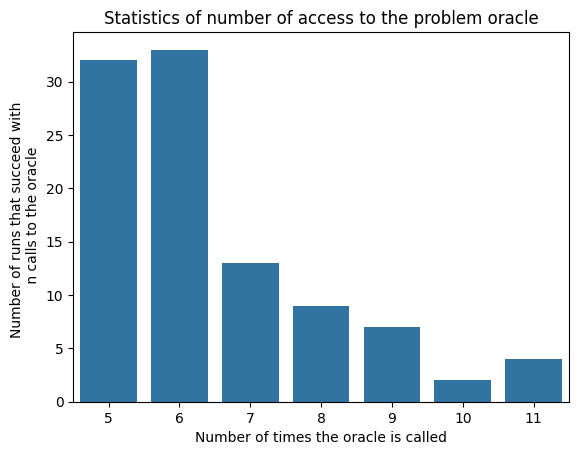

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(stats)
ax.set(
    xlabel='Number of times the oracle is called',
    ylabel="Number of runs that succeed with \n n calls to the oracle",
    title="Statistics of number of access to the problem oracle"
)
plt.show()